In [1]:
import utils
import opt

from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def test(X, Y, Sn, S, H, Cy, Cy_samp, args):
    err_H = np.zeros((len(funcs), 2))
    err_S = np.zeros((len(funcs), 2))

    norm_h = (H**2).sum()
    norm_A = N*(N-1)
    import warnings
    warnings.filterwarnings('ignore')

    for i, f in enumerate(funcs):
        for j, cy_use in enumerate(["real", "samp"]):

            if cy_use == "real":
                Cy_exp = Cy
            elif cy_use == "samp":
                Cy_exp = Cy_samp
            else:
                raise NotImplementedError("Choose either real or samp covariance")

            if f in args[cy_use]:
                params = args[cy_use][f]
            else:
                params = []
            
            iter, H_est, S_est = getattr(opt, f)(X, Y, Sn, Cy_exp, params)

            err_H[i,j] = ((H - H_est)**2).sum()/norm_h
            err_S[i,j] = ((S - S_est)**2).sum()/norm_A
            #print(f"Function {f} took {iter} iterations on covariance {cy_use}")
        
    return err_H, err_S

In [3]:
def objective(args, p_n, M, K, eps):

    err_H = np.zeros((n_graphs, len(funcs), 2))
    err_S = np.zeros((n_graphs, len(funcs), 2))

    with Pool(processes = n_procs) as pool:

        results = []

        for i in range(n_graphs):

            X, Y, Cy, Cy_samp, H, S, Sn = utils.gen_data(N, M, p_er, p_n, eps, K)

            res = pool.apply_async(test, args=[X, Y, Sn, S, H, Cy, Cy_samp, args])
            results.append(res)

        for i in range(n_graphs):

            err_H[i,:,:], err_S[i,:,:] = results[i].get()

    dict_res = {}
    for i, cy_use in enumerate(["real", "samp"]):

        dict_res[cy_use] = {
            'med_H': np.median(err_H, 0)[:,i],
            'std_H': np.std(err_H, 0)[:,i],
            'mean_H': np.mean(err_H, 0)[:,i],
            'mean_S': np.mean(err_S, 0)[:,i],
            'med_S': np.median(err_S, 0)[:,i],
            'std_S': np.std(err_S, 0)[:,i]
        }
    return dict_res

In [4]:
n_graphs = 64

N = 20
p_er = 0.25

noise = [0., 0.01, 0.02, 0.03, 0.04, 0.05]
samples = [10, 20, 40, 100]
Ks = [2,3,4,5]
eps_vals = [0.05, 0.1, 0.15, 0.2]

n_procs = min(cpu_count(), n_graphs)

p_n_default = 0.05 # Default values
M_default = 15
K_default = 4
eps_default = 0.1

max_iters = 10

funcs = ['estH_unpertS', 'estH_denS', 'estH_iter', 'estH_iter_rew']

# Alternative
args_H = {
    'real': {
        'estH_denS': [1, 0.1], #[gamma, delta],
        'estH_iter': [1, 0.1, 1, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 1, 0.1, 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }, 
    'samp': {
        'estH_denS': [0.1, 1], #[gamma, delta_samp],
        'estH_iter': [1, 0.001, 0.01, 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 0.01, 0.0001, 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }
}

args_no_st = {
    'real': {
        'estH_denS': [1, 0.1], #[gamma, delta],
        'estH_iter': [1, 0.1, 0., 1.1], #[lambd, gamma, delta, inc_gamma],
        'estH_iter_rew': [1, 1, 0., 0.01, 1.1] #[lambd, gamma, delta, beta, inc_gamma]
    }, 
    'samp': {
        'estH_denS': [0.1, 1], #[gamma, delta_samp],
        'estH_iter': [1, 0.001, 0., 1.1], #[lambd, gamma, delta_samp, inc_gamma],
        'estH_iter_rew': [1, 0.01, 0., 0.01, 1.1] #[lambd, gamma, delta_samp, beta, inc_gamma]
    }
}
args = args_H

# Noise experiment

In [5]:
results_noise = {}
for n in noise:
    print(f"Starting {n}", flush=True)
    results_noise[n] = objective(args, n, M_default, K_default, eps_default)

Starting 0.0
Starting 0.01
Starting 0.02
Starting 0.03
Starting 0.04
Starting 0.05


Text(0.5, 0, 'Noise power')

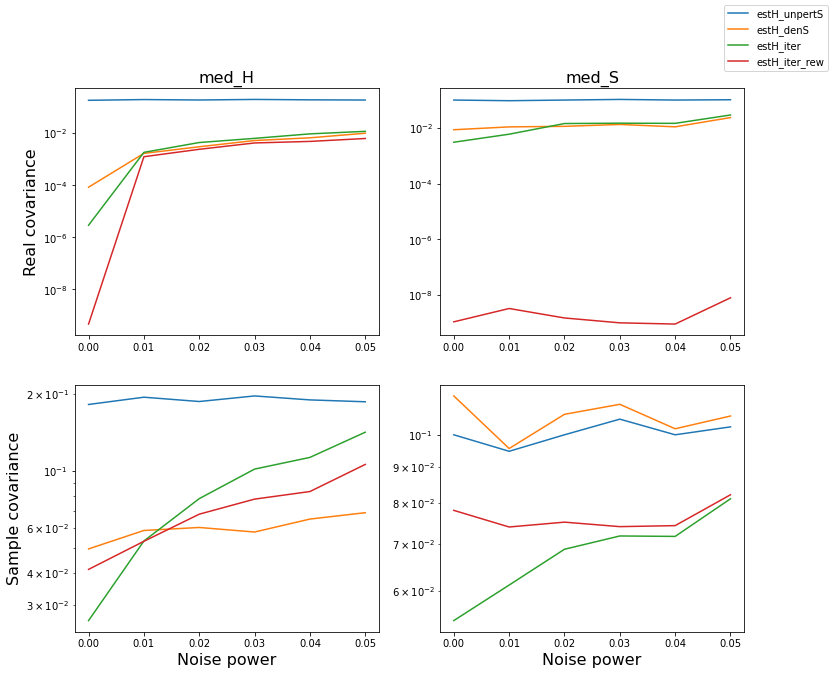

In [6]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].semilogy(noise, [r['real'][param_0][i] for r in results_noise.values()])
    ax[0,1].semilogy(noise, [r['real'][param_1][i] for r in results_noise.values()])
    ax[1,0].semilogy(noise, [r['samp'][param_0][i] for r in results_noise.values()])
    ax[1,1].semilogy(noise, [r['samp'][param_1][i] for r in results_noise.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Noise power", fontsize=16)
ax[1,1].set_xlabel("Noise power", fontsize=16)

Text(0.5, 0, 'Noise power')

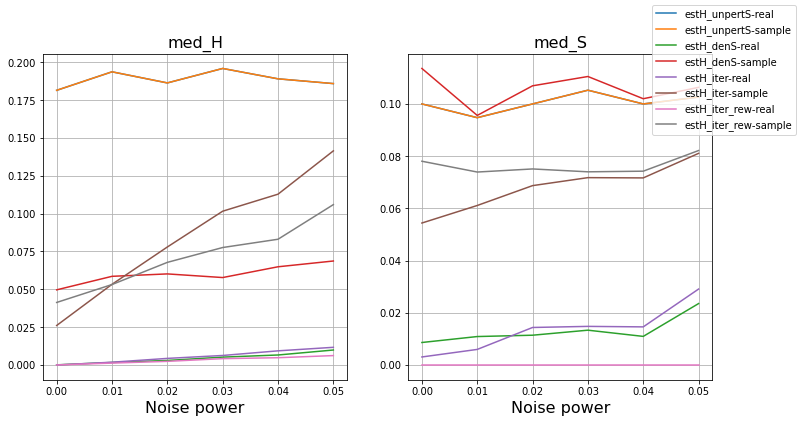

In [7]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(noise, [r['real'][param_0][i] for r in results_noise.values()], label=f"{f}-real")
    ax[1].plot(noise, [r['real'][param_1][i] for r in results_noise.values()])
    ax[0].plot(noise, [r['samp'][param_0][i] for r in results_noise.values()], label=f"{f}-sample")
    ax[1].plot(noise, [r['samp'][param_1][i] for r in results_noise.values()])
fig.legend()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Noise power", fontsize=16)
ax[1].set_xlabel("Noise power", fontsize=16)

# Samples experiment

In [8]:
results_samples = {}
for s in samples:
    print(f"Starting {s}", flush=True)
    results_samples[s] = objective(args_H, p_n_default, s, K_default, eps_default)

Starting 10
Starting 20
Starting 40
Starting 100


Text(0.5, 0, 'Number of samples')

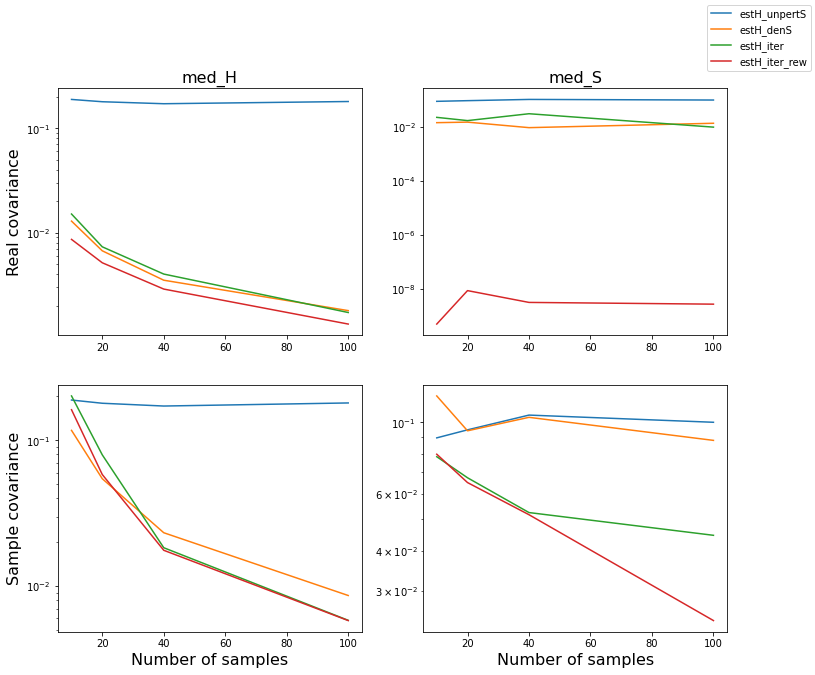

In [9]:
fig, ax = plt.subplots(2,2,figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].semilogy(samples, [r['real'][param_0][i] for r in results_samples.values()])
    ax[0,1].semilogy(samples, [r['real'][param_1][i] for r in results_samples.values()])
    ax[1,0].semilogy(samples, [r['samp'][param_0][i] for r in results_samples.values()])
    ax[1,1].semilogy(samples, [r['samp'][param_1][i] for r in results_samples.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Number of samples", fontsize=16)
ax[1,1].set_xlabel("Number of samples", fontsize=16)

Text(0.5, 0, 'Number of samples')

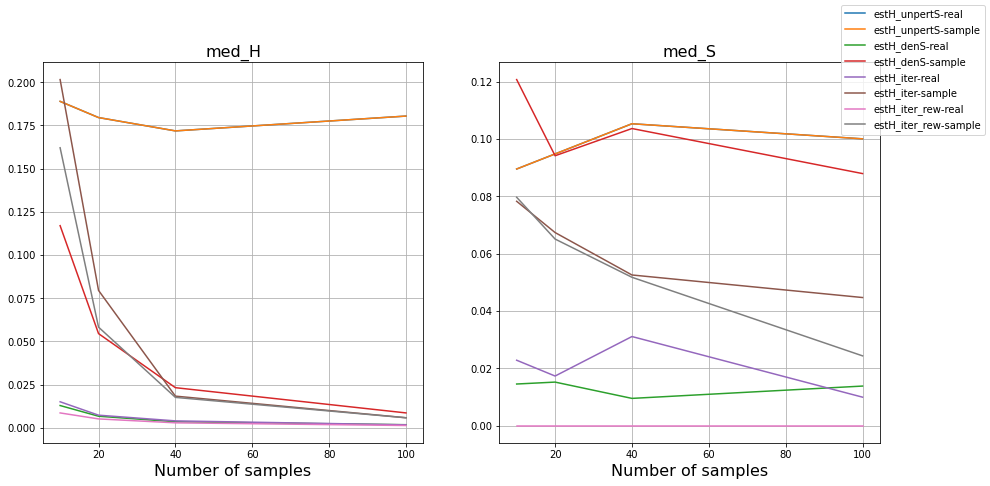

In [10]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(samples, [r['real'][param_0][i] for r in results_samples.values()], label=f"{f}-real")
    ax[1].plot(samples, [r['real'][param_1][i] for r in results_samples.values()])
    ax[0].plot(samples, [r['samp'][param_0][i] for r in results_samples.values()], label=f"{f}-sample")
    ax[1].plot(samples, [r['samp'][param_1][i] for r in results_samples.values()])
fig.legend()
ax[0].grid()
ax[1].grid()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].set_xlabel("Number of samples", fontsize=16)
ax[1].set_xlabel("Number of samples", fontsize=16)

# Filter order experiment

In [11]:
results_K = {}
for k in Ks:
    print(f"Starting {k}", flush=True)
    results_K[k] = objective(args, p_n_default, M_default, k, eps_default)

Starting 2
Starting 3
Starting 4
Starting 5


Text(0.5, 0, 'Filter order')

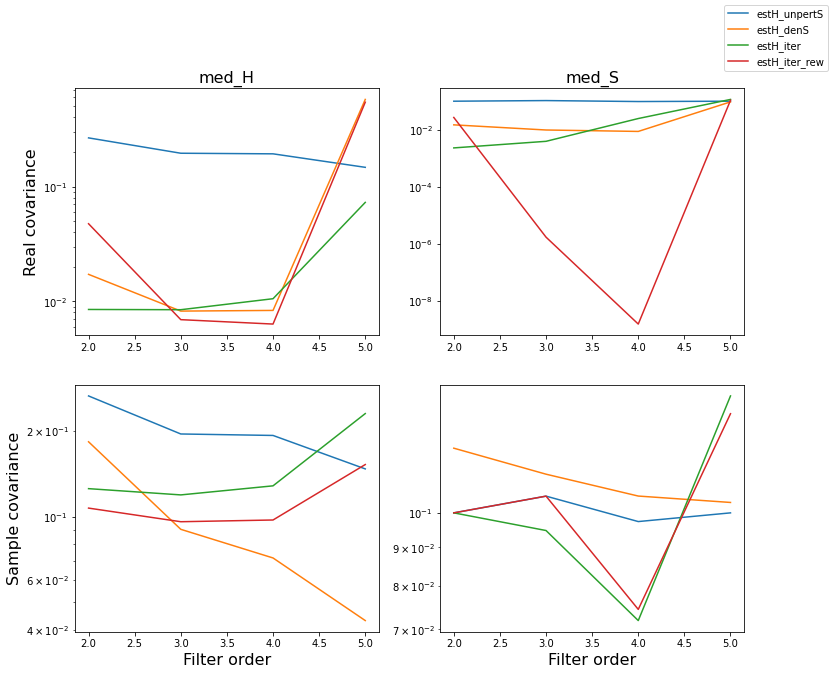

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].semilogy(Ks, [r['real'][param_0][i] for r in results_K.values()])
    ax[0,1].semilogy(Ks, [r['real'][param_1][i] for r in results_K.values()])
    ax[1,0].semilogy(Ks, [r['samp'][param_0][i] for r in results_K.values()])
    ax[1,1].semilogy(Ks, [r['samp'][param_1][i] for r in results_K.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Filter order", fontsize=16)
ax[1,1].set_xlabel("Filter order", fontsize=16)

Text(0.5, 0, 'Filter order')

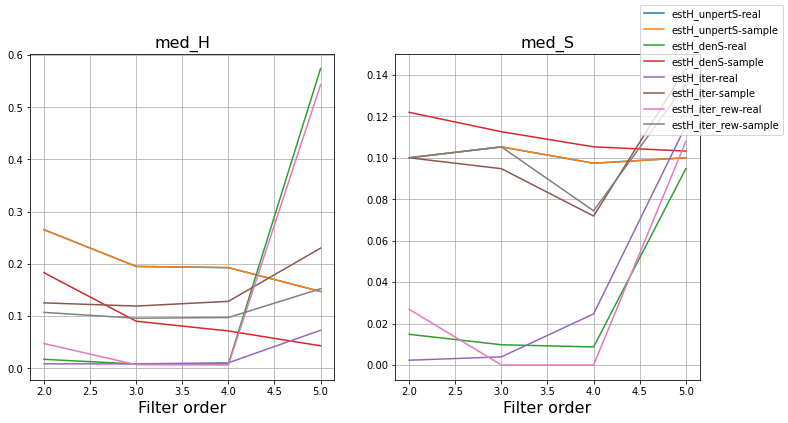

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(Ks, [r['real'][param_0][i] for r in results_K.values()], label=f"{f}-real")
    ax[1].plot(Ks, [r['real'][param_1][i] for r in results_K.values()])
    ax[0].plot(Ks, [r['samp'][param_0][i] for r in results_K.values()], label=f"{f}-sample")
    ax[1].plot(Ks, [r['samp'][param_1][i] for r in results_K.values()])
fig.legend()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Filter order", fontsize=16)
ax[1].set_xlabel("Filter order", fontsize=16)

# Adjacency perturbation experiment

In [14]:
results_eps = {}
for eps in eps_vals:
    print(f"Starting {eps}", flush=True)
    results_eps[eps] = objective(args, p_n_default, M_default, K_default, eps)

Starting 0.05
Starting 0.1
Starting 0.15
Starting 0.2


Text(0.5, 0, 'Perturbation pct')

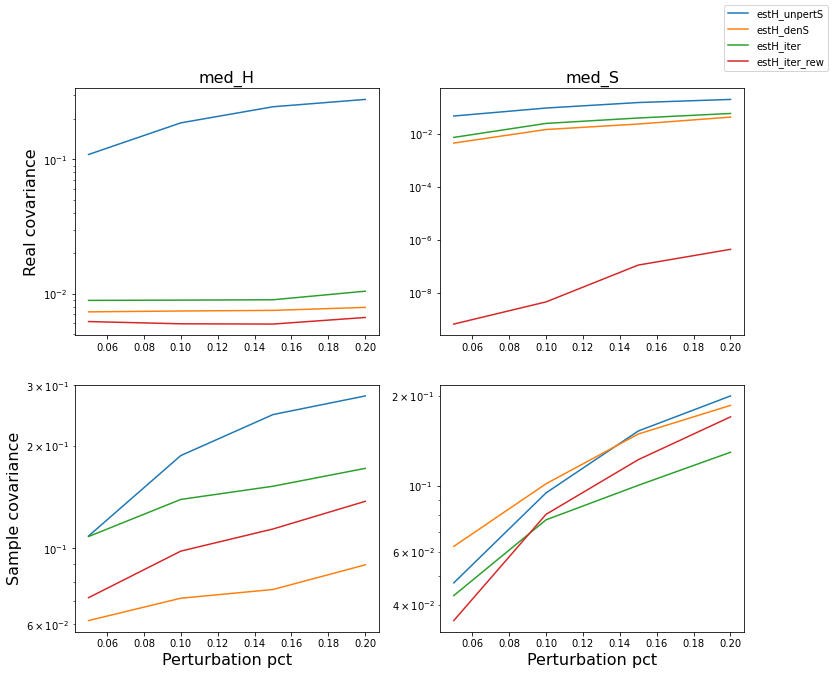

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0,0].semilogy(eps_vals, [r['real'][param_0][i] for r in results_eps.values()])
    ax[0,1].semilogy(eps_vals, [r['real'][param_1][i] for r in results_eps.values()])
    ax[1,0].semilogy(eps_vals, [r['samp'][param_0][i] for r in results_eps.values()])
    ax[1,1].semilogy(eps_vals, [r['samp'][param_1][i] for r in results_eps.values()])
fig.legend(funcs)
ax[0,0].set_title(param_0, fontsize=16)
ax[0,1].set_title(param_1, fontsize=16)
ax[0,0].set_ylabel("Real covariance", fontsize=16)
ax[1,0].set_ylabel("Sample covariance", fontsize=16)
ax[1,0].set_xlabel("Perturbation pct", fontsize=16)
ax[1,1].set_xlabel("Perturbation pct", fontsize=16)

Text(0.5, 0, 'Perturbation pct')

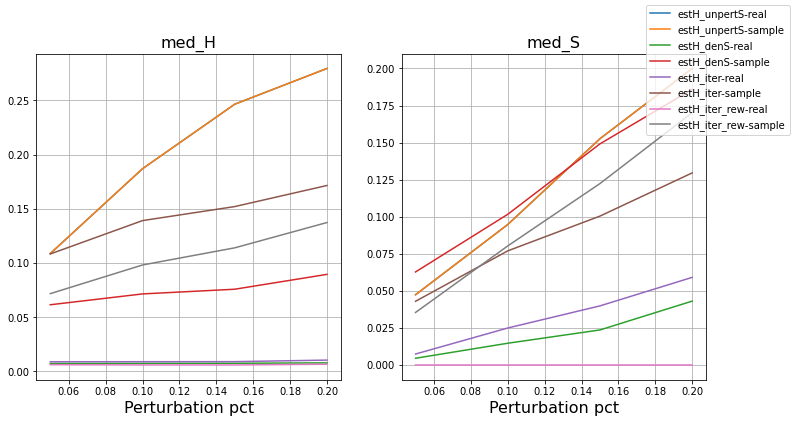

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
param_0 = 'med_H'
param_1 = 'med_S'
for i, f in enumerate(funcs):
    ax[0].plot(eps_vals, [r['real'][param_0][i] for r in results_eps.values()], label=f"{f}-real")
    ax[1].plot(eps_vals, [r['real'][param_1][i] for r in results_eps.values()])
    ax[0].plot(eps_vals, [r['samp'][param_0][i] for r in results_eps.values()], label=f"{f}-sample")
    ax[1].plot(eps_vals, [r['samp'][param_1][i] for r in results_eps.values()])
fig.legend()
ax[0].set_title(param_0, fontsize=16)
ax[1].set_title(param_1, fontsize=16)
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel("Perturbation pct", fontsize=16)
ax[1].set_xlabel("Perturbation pct", fontsize=16)